# Earthquake seismology with DAS

#### Todo List:
1. Reference earthquakes by Evid rather than dataframe index
2. Make a map of all of the detected events
3. Try some xcorr
4. Focal Mechanisms


In [1]:
import h5py
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import numpy as np
import datetime
import pandas as pd
from dasquakes import * 
import obspy
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
from libcomcat.search import search
from libcomcat.dataframes import get_summary_data_frame
from tqdm import tqdm
import geopy.distance
import warnings
warnings.filterwarnings("ignore")

### Get a list of events from USGS

In [2]:
events = search(starttime = datetime.datetime(2022, 3, 17, 0, 0), 
                endtime   = datetime.datetime.now(),
                maxradiuskm=500,
                minmagnitude=3,
                latitude=47.60, 
                longitude=-122.33)

coords_1=(47.60,-122.33)
print("Returned %s events" % len(events))
event_df = get_summary_data_frame(events)
event_df['dist']=np.zeros(len(event_df))

Returned 13 events


In [3]:
for i in range(0,len(event_df)):
    event_df.dist[i]=geopy.distance.geodesic(coords_1, (event_df.latitude[i],event_df.longitude[i])).km

In [4]:
event_df = event_df.sort_values(by=['dist'],ascending=True)
event_df=event_df.reset_index(drop=True)
event_df.iloc[0:50]
detected_quakes = event_df.id

In [5]:
detected_quakes

0     uw61869652
1     uw61860022
2     uw61832097
3     uw61835766
4     uw61836427
5     uw61882431
6     uw61862977
7     uw61886506
8     us7000ishe
9     us6000iac9
10    us6000hn38
11    us6000i90r
12    us6000ipd3
Name: id, dtype: object

### Storing What Earthquakes have DAS data

In [6]:
EQwithDAS=[]
Eventindex=[]

for i in range(0,len(event_df)):
    this_id = detected_quakes[i]
    this_event = event_df[event_df.id==this_id]
    t0 = this_event['time'].iloc[0]

    cable = 'seadasn'
    record_length = 10 #minutes

    prefix, network_name, datastore = data_wrangler(cable,record_length, t0)

    try:
        data,dates,attrs,errors = open_sintela_file(prefix,
                                         t0,
                                         datastore,
                                         number_of_files=record_length,
                                         verbose=True);
        errors=0
    except:
        errors=1

    if errors==0:
        EQwithDAS.append(this_id)
        Eventindex.append(i)
del data, dates, attrs,errors

In [7]:
event_df.iloc[Eventindex]

,id,time,location,latitude,longitude,depth,magnitude,alert,url,eventtype,significance,dist
2,uw61832097,2022-05-17 08:07:34.400,"6 km ENE of Oso, Washington",48.299667,-121.852000,3.530,3.40,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,280,85.597546
3,uw61835766,2022-05-01 11:15:56.460,"2 km E of Mount Vernon, Washington",48.423500,-122.305500,13.540,3.56,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,424,91.583659
4,uw61836427,2022-05-28 19:07:44.030,"55 km NE of Marblemount, Washington",48.807833,-120.822500,-0.060,3.16,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,157,174.902878
5,uw61882431,2022-09-22 14:41:56.900,"26 km WNW of Forks, Washington",48.046500,-124.715000,37.040,3.49,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,190,185.351591
7,uw61886506,2022-10-07 12:52:36.010,"16 km ESE of Lacomb, Oregon",44.540333,-122.550833,13.170,4.39,green,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,896,340.518591
8,us7000ishe,2022-11-26 03:50:16.402,"28 km WNW of Tofino, Canada",49.226400,-126.286800,31.289,4.90,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,527,344.177874
10,us6000hn38,2022-05-22 09:58:57.424,"2 km WSW of Mullan, Idaho",47.458000,-115.834800,5.000,3.00,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,142,489.213670
11,us6000i90r,2022-08-08 07:38:56.410,"201 km W of Tofino, Canada",48.973600,-128.652200,10.000,4.60,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,326,493.234051
12,us6000ipd3,2022-09-29 15:09:32.565,off the coast of Washington,47.637400,-128.921800,10.555,3.30,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,168,495.397454


### Load DAS Data for specific events with data

In [ ]:
this_id = EQwithDAS[0]

In [9]:

this_event = event_df[event_df.id==this_id]
t0 = this_event['time'].iloc[0]
cable = 'seadasn'
record_length = 10 #minutes

prefix, network_name, datastore = data_wrangler(cable,record_length, t0)
data,dates,attrs,errors = open_sintela_file(prefix,
                                     t0,
                                     datastore,
                                     number_of_files=record_length,
                                     verbose=True)
x_max=data.shape[1] * attrs['SpatialSamplingInterval']

In [10]:
data.shape

(60000, 1749)

In [48]:
low_cut = 0.1
hi_cut = 1

b,a = butter(2,(low_cut,hi_cut),'bp',fs=attrs['MaximumFrequency'])
data_filt = filtfilt(b,a,data,axis=0)

In [49]:
client = Client("IRIS")

t1 = UTCDateTime( t0.strftime("%Y-%m-%dT%H:%M:%S") )
dt = datetime.timedelta(minutes=record_length)
t2 = UTCDateTime( (t0+dt).strftime("%Y-%m-%dT%H:%M:%S") )

st = client.get_waveforms("UW", "NOWS", "--", "HNN", t1, t2, attach_response=True)
# st.decimate(5, strict_length=False, no_filter=False) #everything should be at 40Hz now
st2 = client.get_waveforms("IU", "COR", "00", "HH1", t1, t2, attach_response=True)

pre_filt = (low_cut/2, low_cut, hi_cut, hi_cut*2)
st.remove_response(output='VEL', pre_filt=pre_filt)
st2.remove_response(output='VEL', pre_filt=pre_filt)

1 Trace(s) in Stream:
IU.COR.00.HH1 | 2022-05-17T08:07:34.008393Z - 2022-05-17T08:17:33.998393Z | 100.0 Hz, 60000 samples

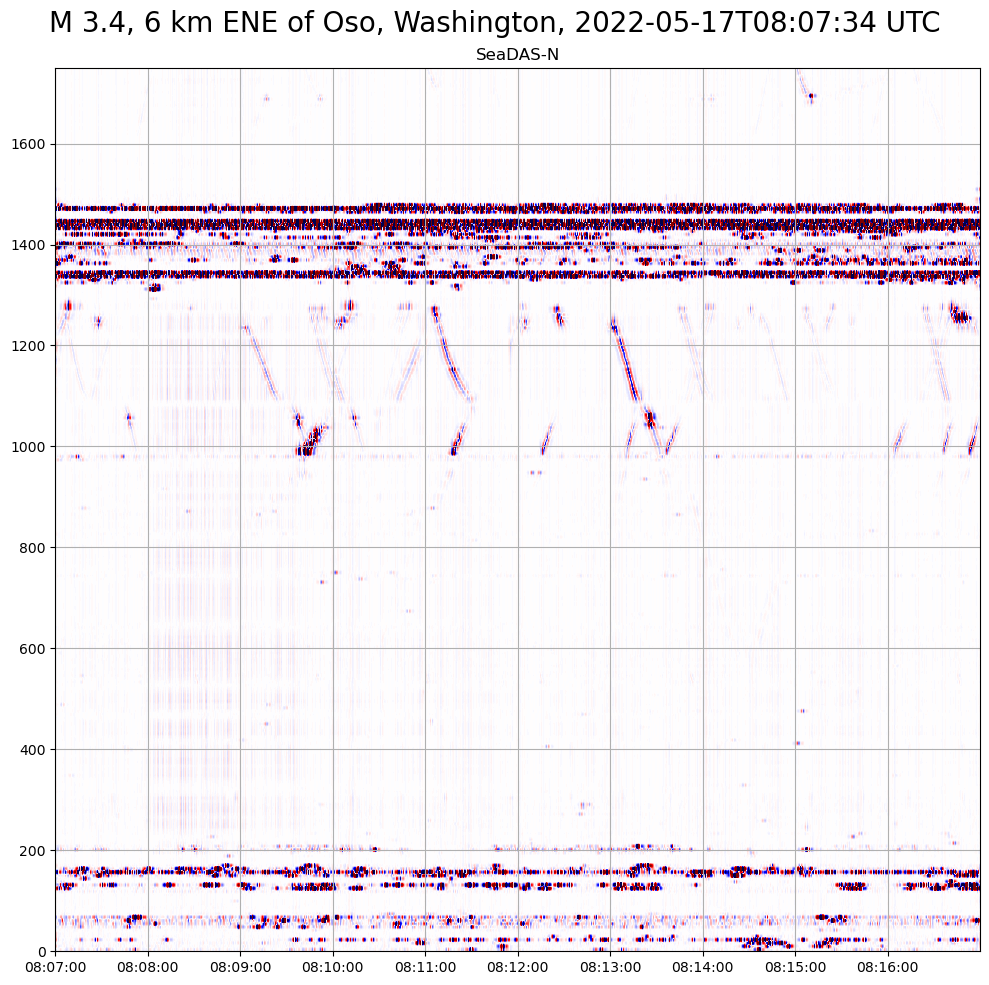

In [50]:
stitle=f"M {this_event['magnitude'].to_numpy()[0]}, "\
       f"{this_event['location'].to_numpy()[0]}, "\
       f"{str(this_event['time'].to_numpy()[0])[0:-10]} UTC"

data_quicklook(dates,data_filt,x_max,stitle,filename=None,das_vmax=2,network_name=network_name,ylim=[0,1749])

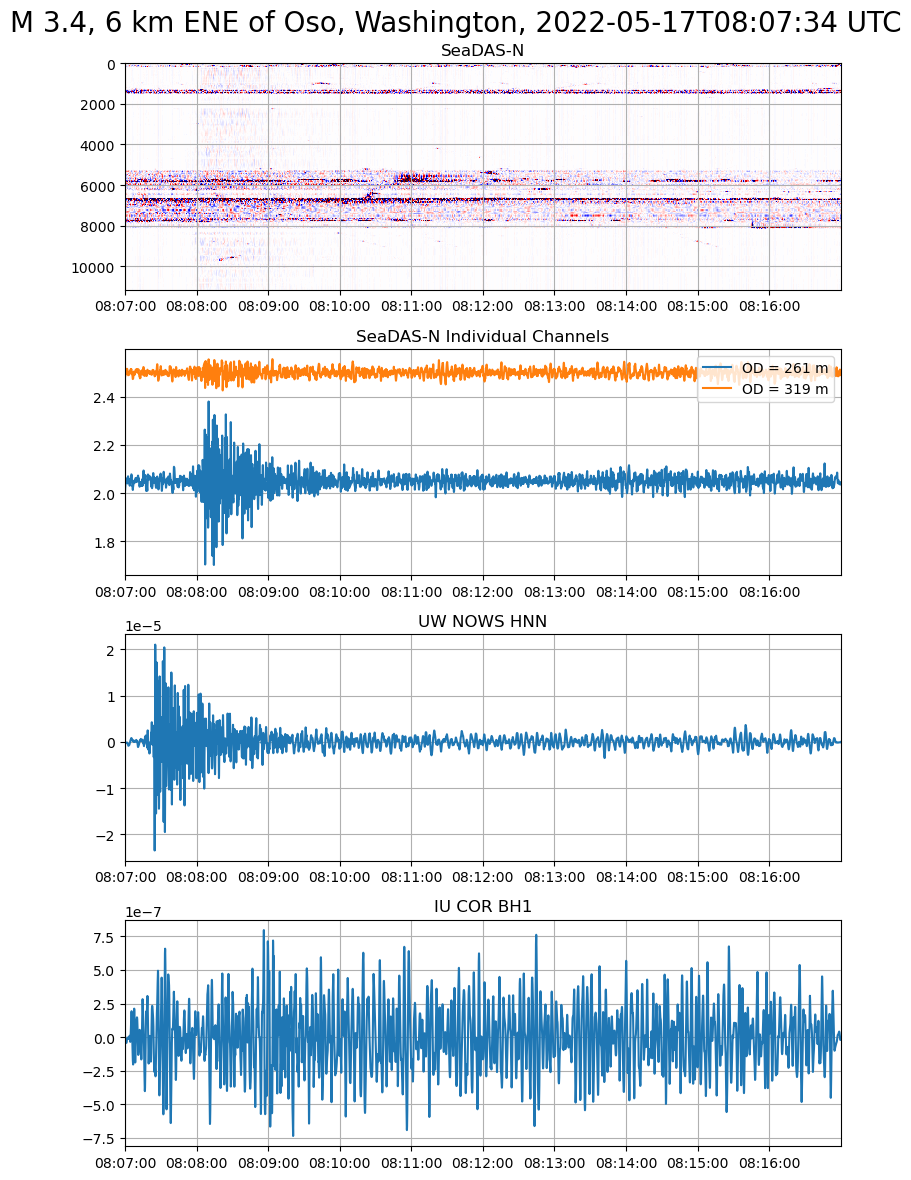

In [51]:
# nombre = f"figures/{event_df.iloc[catalog_index]['Evid']}.png"
# local_earthquake_quicklook(dates,data_filt,st,st2,x_max,event_df,catalog_index,filename=nombre)

#vmax=0.02
stitle=f"M {this_event['magnitude'].to_numpy()[0]}, "\
       f"{this_event['location'].to_numpy()[0]}, "\
       f"{str(this_event['time'].to_numpy()[0])[0:-10]} UTC"


local_earthquake_quicklook(dates,data_filt,st,st2,x_max,
                           stitle,das_vmax=2,
                           network_name=network_name)

In [52]:
np.correlate([1, 2, 3], [0, 1, 0.5])

array([3.5])

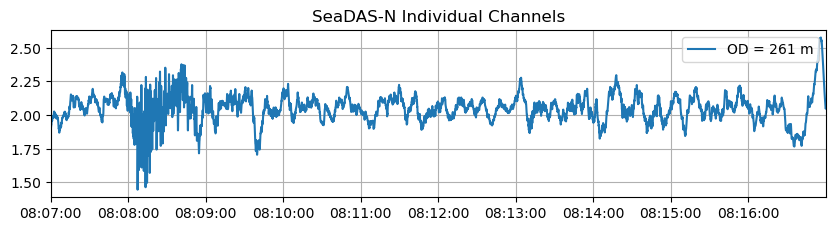

In [29]:
    low_cut = 0.01
    hi_cut = 2

    b,a = butter(2,(low_cut,hi_cut),'bp',fs=attrs['MaximumFrequency'])
    data_filt = filtfilt(b,a,data,axis=0)
    
    import matplotlib.dates as mdates
    dx = x_max / data_filt.shape[1]
    fig,ax=plt.subplots(figsize=(10,10))
    date_format = mdates.DateFormatter('%H:%M:%S')
    
    ax = plt.subplot(4,1,1)
    fig.patch.set_facecolor('w')
    graph_spacing = -20
    #,400,800,1400
    jj=41
    plt.plot(dates,data_filt[:,jj]-jj/graph_spacing,label=f'OD = {int(jj*dx)} m')
    plt.legend(loc='upper right')
    ax.set_title(f'{network_name} Individual Channels')
    ax.xaxis.set_major_formatter(date_format)
    ax.xaxis_date()
    ax.autoscale(enable=True, axis='x', tight=True)
    plt.grid()

In [ ]:
this_event.url.to_list()[0]
len(data_filt)
data_filt

In [ ]:
from tqdm import tqdm
xc = np.zeros((119999,174))

for i in tqdm(range(174)):
    xc[:,i] = np.correlate(np.sign(data_filt[:,30]),
                           np.sign(data_filt[:,i*10]),
                           mode='full')

In [ ]:
fig,ax=plt.subplots()
plt.imshow(xc.T,aspect='auto',vmin=-1000,vmax=1000)
# plt.plot(data_filt[:,30])
# plt.plot(data_filt[:,40])
#plt.xlim(18000-1e3,18000+1e3)
plt.colorbar()

In [ ]:
tqdm(range(174))

In [ ]:
fig,ax=plt.subplots()
# plt.imshow(xc.T,aspect='auto',vmin=-0.1,vmax=0.1)
plt.plot(data_filt[:,40])
plt.plot(data_filt[:,30],alpha=0.5)
#plt.xlim(0,100)
plt.show()

In [ ]:
a=1